# Result Evaluation

The following notebook analyzes the training (see chapter 1) and validation (see chapter 2) results.

# 1) Investigate Training Results
## 1a) Convert Logs to DataFrames

In [5]:
import glob
import pandas as pd
import re

log_folder_path = '../logs'

for log_file in glob.glob(f'{log_folder_path}/*.txt'):
    logs_train = pd.DataFrame(columns=['Epoch', 'Batch', 'Training Loss', 'Training Accuracy'])
    logs_val = pd.DataFrame(columns=['Epoch', 'Validation Loss', 'Validation Accuracy'])

    for line in open(log_file, 'r').readlines():
        if line.startswith(('Device', 'Number', 'Trigger', 'Best', 'Training', 'Process')) or line == '\n':
            continue
        elif line.startswith('Epoch'):
            epoch = line.split(':')[1].strip()
        elif line.startswith('Batch'):
            splitted_line = re.split('[,:]+', line)
            batch, train_loss, train_acc = splitted_line[1].strip(), splitted_line[3].strip(), splitted_line[5].strip()
            new_row = pd.DataFrame([{'Epoch': epoch, 'Batch': batch, 'Training Loss': train_loss, 'Training Accuracy': train_acc}])
            logs_train = pd.concat([logs_train, new_row], ignore_index=True)
        elif line.startswith('Validation'):
            splitted_line = re.split('[,:]+', line)
            val_loss, val_acc = splitted_line[1].strip(), splitted_line[3].strip()
            new_row = pd.DataFrame([{'Epoch': epoch, 'Validation Loss': val_loss, 'Validation Accuracy': val_acc}])
            logs_val = pd.concat([logs_val, new_row], ignore_index=True)
        else:
            print(f'Unexpected line found in {log_file}: {line}')

    logs_train.to_csv(f'{log_folder_path}/{log_file.split("_")[-3]}_{log_file.split("_")[-2]}_{log_file.split("_")[-1].split(".")[0]}_training.csv', index=False)
    logs_val.to_csv(f'{log_folder_path}/{log_file.split("_")[-3]}_{log_file.split("_")[-2]}_{log_file.split("_")[-1].split(".")[0]}_validation.csv', index=False)

In [27]:
max = 8
cut = 'Before'
epochs = 5

In [28]:
chosen_logs_train = pd.read_csv(f'../logs/max{max}_cut{cut}_{epochs}epochs_training.csv')
chosen_logs_train

,Epoch,Batch,Training Loss,Training Accuracy
0,0,0,0.623132,88.800007
1,0,1,0.544331,91.200006
2,0,2,0.490034,91.000003
3,0,3,0.435472,90.800005
4,0,4,0.402330,90.200007
...,...,...,...,...
15595,4,3115,0.208629,93.800002
15596,4,3116,0.263678,90.600002
15597,4,3117,0.246882,91.200006
15598,4,3118,0.236029,92.200005


In [29]:
chosen_logs_val = pd.read_csv(f'../logs/max{max}_cut{cut}_{epochs}epochs_validation.csv')
chosen_logs_val

,Epoch,Validation Loss,Validation Accuracy
0,0,0.252836,92.291286
1,1,0.249188,92.220004
2,2,0.244110,92.255389
3,3,0.238757,92.303594
4,4,0.233898,92.360004


## 1b) Get Best Model

In [30]:
chosen_logs_train.iloc[chosen_logs_train['Training Accuracy'].idxmax()]

Epoch                   4.000000
Batch                1562.000000
Training Loss           0.148569
Training Accuracy      96.000004
Name: 14042, dtype: float64

In [31]:
chosen_logs_val.iloc[chosen_logs_val['Validation Accuracy'].idxmax()]

Epoch                   4.000000
Validation Loss         0.233898
Validation Accuracy    92.360004
Name: 4, dtype: float64

## 1c) Get Mean Loss and Accuracy per Epoch

In [32]:
chosen_logs_train.groupby('Epoch')['Training Loss'].mean()

Epoch
0    0.271457
1    0.255667
2    0.247358
3    0.240780
4    0.234268
Name: Training Loss, dtype: float64

In [33]:
chosen_logs_val.groupby('Epoch')['Validation Loss'].mean()

Epoch
0    0.252836
1    0.249188
2    0.244110
3    0.238757
4    0.233898
Name: Validation Loss, dtype: float64

In [34]:
chosen_logs_train.groupby('Epoch')['Training Accuracy'].mean()

Epoch
0    91.671991
1    91.745132
2    91.845581
3    91.960325
4    92.097120
Name: Training Accuracy, dtype: float64

In [35]:
chosen_logs_val.groupby('Epoch')['Validation Accuracy'].mean()

Epoch
0    92.291286
1    92.220004
2    92.255389
3    92.303594
4    92.360004
Name: Validation Accuracy, dtype: float64

## 1d) Plot Training and Validation Loss over Time

C:\Users\ninai\AppData\Local\Temp\ipykernel_10420\1409899726.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(plotdata1['Epoch'])


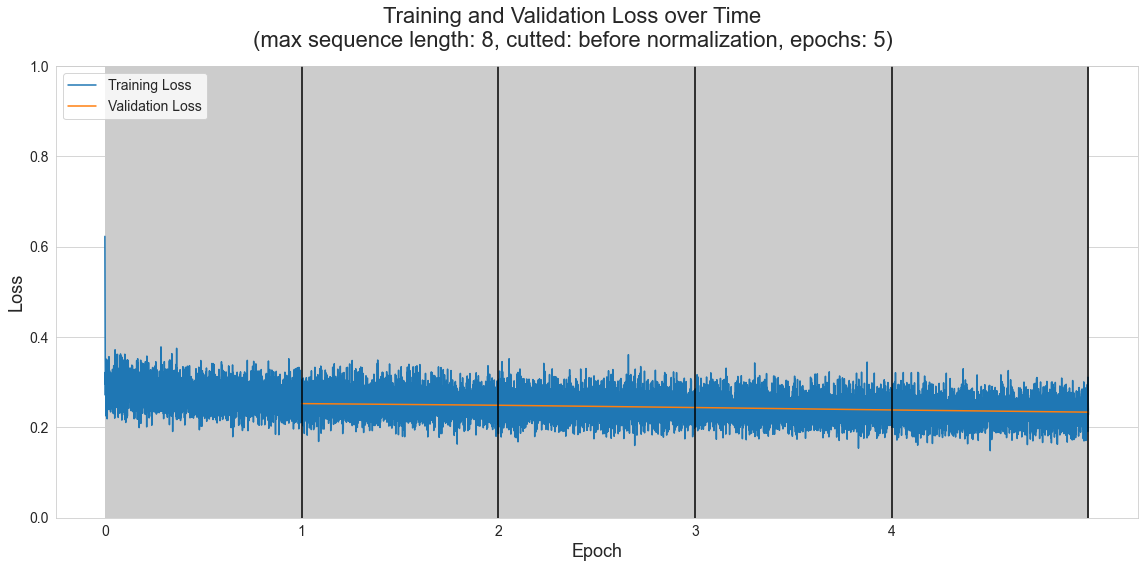

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(16, 8))
fig.patch.set_facecolor('white')
ax.set_facecolor('white') 

# add blue line for training loss per batch
plotdata1 = chosen_logs_train
plotdata1['Epoch_Batch'] = plotdata1['Epoch'].astype(str) + plotdata1['Batch'].astype(str)
sns.lineplot(data=plotdata1,
             x='Epoch_Batch',
             y='Training Loss',
             ax=ax,
             color='tab:blue',
             label='Training Loss')

fig.suptitle(f'Training and Validation Loss over Time\n(max sequence length: {max}, cutted: {cut.lower()} normalization, epochs: {epochs})', fontsize=22)
ax.set(ylim=(0.0, 1.0))
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.rc('legend', fontsize=14)

# remove batch x-tick labels
for i, x_tick in enumerate(ax.xaxis.get_ticklabels()):
    if not i % plotdata1['Batch'].nunique() == 0:
        x_tick.set_visible(False)

# make epoch-batch combination to epoch only again as x-tick labels
ax.set_xticklabels(plotdata1['Epoch'])

# add orange line for validation loss per epoch
plotdata2 = chosen_logs_val
plotdata2['Shifted_Epoch'] = (plotdata2['Epoch'] * plotdata1['Batch'].nunique()) + (plotdata1['Batch'].nunique() - 1)
sns.lineplot(data=plotdata2,
             ax=ax,
             x='Shifted_Epoch',
             y='Validation Loss',
             color='tab:orange',
             label='Validation Loss')

# mark with vertical line where validation loss was measured/ epoch ends
for epoch_end in plotdata2['Shifted_Epoch']:
    plt.axvline(epoch_end, color='black')

plt.tight_layout()
plt.savefig(f'../plots/max{max}_cut{cut}_epochs{epochs}_both_losses_over_time.png', dpi=300)
#plt.close()

In [ ]:
# TODO: same plot like above, but for accuracy

# 2. Investigate Classification Results

In [ ]:
# TODO: merge CSVs of different classification batches
# TODO: merge classification results with GT labels
# TODO: calc decision matrix, acc, precision, recall, f1s, auc, roc
# TODO: plot results -> acc vs. max len, acc etc. (see Kubas paper)